# Create Daily Dataset

this notebook creates a daily dataset, using the dataset with hourly data but using new hourly evaporation data from meteo suisse 

In [1]:
import pandas as pd

df = pd.read_csv("../../Data/clean_data/data_hourly_reduced_variables.csv")

eva =pd.read_csv("../../Data/raw_data/all_data_raw/evaporation_raw_data.txt", sep=";")


In [4]:
eva

,stn,time,ets150d0,erefaod0
0,WAE,20120101,0.03,0.3
1,WAE,20120102,0.04,0.7
2,WAE,20120103,0.25,0.2
3,WAE,20120104,0.11,0.7
4,WAE,20120105,0.06,1.3
...,...,...,...,...
11925,SMA,20221115,0.13,0.4
11926,SMA,20221116,0.44,0.6
11927,SMA,20221117,0.34,1.2
11928,SMA,20221118,0.10,0.6


# convert data_reduced_variables to daily format

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60754 entries, 2012-01-01 00:00:00+00:00 to 2019-11-27 04:00:00+00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   60754 non-null  float64
 1   suction_tension (40cm)   60754 non-null  float64
 2   suction_tension (70cm)   60754 non-null  float64
 3   water_temperature        60754 non-null  float64
 4   barometric_pressure_qfe  60754 non-null  float64
 5   dew_point                60754 non-null  float64
 6   water_level              60754 non-null  float64
 7   precipitation (mm)       60754 non-null  float64
 8   change_rate              60754 non-null  float64
 9   inflow_linth (m3/s)      60754 non-null  float64
 10  outflow_limmat (m3/s)    60754 non-null  float64
 11  evaporation              60754 non-null  float64
dtypes: float64(12)
memory usage: 6.0 MB


In [3]:
# convert DateTime column into datetime format
df["datetime"] = pd.to_datetime(df['datetime'], utc=True)

# set DateTime as index
df.set_index("datetime", inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60754 entries, 2012-01-01 00:00:00+00:00 to 2019-11-27 04:00:00+00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   60754 non-null  float64
 1   suction_tension (40cm)   60754 non-null  float64
 2   suction_tension (70cm)   60754 non-null  float64
 3   water_temperature        60754 non-null  float64
 4   barometric_pressure_qfe  60754 non-null  float64
 5   dew_point                60754 non-null  float64
 6   water_level              60754 non-null  float64
 7   precipitation (mm)       60754 non-null  float64
 8   change_rate              60754 non-null  float64
 9   inflow_linth (m3/s)      60754 non-null  float64
 10  outflow_limmat (m3/s)    60754 non-null  float64
 11  evaporation              60754 non-null  float64
dtypes: float64(12)
memory usage: 6.0 MB


In [5]:
# resampling dataframe to daily data by subsetting original dataframe into dataframes where we have to sum the hourly data (dfDS) 
# and dataframes where we have to take the mean of hourly data
dfDS = df[["precipitation (mm)"]].resample("D").sum()

dfDM = df[['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'water_level', "inflow_linth (m3/s)", "outflow_limmat (m3/s)"]].resample("D").mean()


       # somehow when applying the the mean() method to the the resample() method we end up with quite some missing values compared to the
       # sum() method applied to the resample() method,


In [6]:
dfDM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2888 entries, 2012-01-01 00:00:00+00:00 to 2019-11-27 00:00:00+00:00
Freq: D
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2629 non-null   float64
 1   suction_tension (40cm)   2629 non-null   float64
 2   suction_tension (70cm)   2629 non-null   float64
 3   water_temperature        2629 non-null   float64
 4   barometric_pressure_qfe  2629 non-null   float64
 5   dew_point                2629 non-null   float64
 6   water_level              2629 non-null   float64
 7   inflow_linth (m3/s)      2629 non-null   float64
 8   outflow_limmat (m3/s)    2629 non-null   float64
dtypes: float64(9)
memory usage: 225.6 KB


In [9]:
# merge the two datasets again 
dfD = pd.merge(dfDM, dfDS, how = 'inner', on=dfDM.index)#right_index = True, left_index = True)
# set datetime as index
dfD.set_index("key_0", inplace=True)
# change index name
dfD.index.names = ['datetime']
# create variable for change rate of water level since we didn´t want to use the one with hourly data and convert it to daily data
dfD["change_rate"] = dfD["water_level"].pct_change()
# convert datetime index in date only because the datetime index of eva and dfD are not exactly the same 
dfD.index = dfD.index.date
# we drop missing rows
dfD.dropna(inplace=True)

dfD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628 entries, 2012-01-02 to 2019-11-27
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2628 non-null   float64
 1   suction_tension (40cm)   2628 non-null   float64
 2   suction_tension (70cm)   2628 non-null   float64
 3   water_temperature        2628 non-null   float64
 4   barometric_pressure_qfe  2628 non-null   float64
 5   dew_point                2628 non-null   float64
 6   water_level              2628 non-null   float64
 7   inflow_linth (m3/s)      2628 non-null   float64
 8   outflow_limmat (m3/s)    2628 non-null   float64
 9   precipitation (mm)       2628 non-null   float64
 10  change_rate              2628 non-null   float64
dtypes: float64(11)
memory usage: 246.4+ KB


In [10]:
dfD.loc[dfD["water_temperature"].isna()]

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),change_rate


# clean and prepare evaporation dataset

In [11]:
# drop column we don´t need
eva.drop(columns="erefaod0", inplace=True)
# select only observation from one station (Wädenswil)
eva = eva.loc[eva["stn"]=="WAE"]
# drop the column for station names 
eva.drop(columns = "stn", inplace = True)
# rename coumns
eva.rename(columns={"time": "datetime","ets150d0": "Evapotranspiration (mm)"}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
eva

,datetime,Evapotranspiration (mm)
0,20120101,0.03
1,20120102,0.04
2,20120103,0.25
3,20120104,0.11
4,20120105,0.06
...,...,...
3971,20221115,0.14
3972,20221116,0.33
3973,20221117,0.31
3974,20221118,0.12


In [13]:
# import pytz package for handling timezones
import pytz
# convert DateTime column into datetime format
eva["datetime"] = pd.to_datetime(eva['datetime'], utc=True)
# function that converts datetime column into CET timezone and accounts for Daylight saving
def add_timezone(df):
    timeZone = pytz.timezone("CET")
    df['datetime'] = df['datetime'].dt.tz_convert(timeZone)
    return df

add_timezone(eva)

# set DateTime as index
eva.set_index("datetime", inplace=True)
# convert datetime index in date only because the datetime index of eva and dfD are not exactly the same 
eva.index = eva.index.date

In [14]:

eva.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3976 entries, 2012-01-01 to 2022-11-19
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Evapotranspiration (mm)  3976 non-null   object
dtypes: object(1)
memory usage: 62.1+ KB


# Merge the two Datasets


In [15]:
# merge the dfD dataframe with the evaporation dataframe on the index
merged_df = pd.merge(dfD, eva, how = 'inner', right_index = True, left_index = True)

merged_df["Evapotranspiration (mm)"] = merged_df["Evapotranspiration (mm)"].astype(float)
merged_df

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),change_rate,Evapotranspiration (mm)
2012-01-02,2.039583,1.566667,1.750000,6.046528,969.340278,4.945139,405.913889,36.147875,121.737083,8.0,0.000004,0.04
2012-01-03,2.233333,1.737500,1.666667,5.955556,976.234028,0.836111,405.923611,38.953083,120.771542,1.1,0.000024,0.25
2012-01-04,1.716667,1.354167,1.593750,5.911806,974.570833,1.220833,405.927083,39.505792,122.752875,9.9,0.000009,0.11
2012-01-05,1.381250,1.139583,1.522917,5.722917,960.572917,1.400694,405.925972,41.539500,139.602042,21.7,-0.000003,0.06
2012-01-06,1.862500,1.425000,1.533333,5.533333,972.211806,0.190278,405.949028,47.129458,140.766375,1.2,0.000057,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-23,4.266042,3.035208,3.251667,10.308333,949.404167,3.454861,405.948681,45.504083,73.408667,0.0,-0.000026,0.16
2019-11-24,4.538542,3.249375,4.019792,10.232639,958.418056,4.811111,405.941667,43.116500,72.780958,0.0,-0.000017,0.11
2019-11-25,4.732708,3.417917,4.296042,10.204861,962.489306,5.956667,405.942153,41.917542,63.847000,0.0,0.000001,0.06
2019-11-26,4.847292,3.544375,4.295208,10.215694,960.428194,6.743333,405.950972,41.814917,66.054125,0.0,0.000022,0.07


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628 entries, 2012-01-02 to 2019-11-27
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2628 non-null   float64
 1   suction_tension (40cm)   2628 non-null   float64
 2   suction_tension (70cm)   2628 non-null   float64
 3   water_temperature        2628 non-null   float64
 4   barometric_pressure_qfe  2628 non-null   float64
 5   dew_point                2628 non-null   float64
 6   water_level              2628 non-null   float64
 7   inflow_linth (m3/s)      2628 non-null   float64
 8   outflow_limmat (m3/s)    2628 non-null   float64
 9   precipitation (mm)       2628 non-null   float64
 10  change_rate              2628 non-null   float64
 11  Evapotranspiration (mm)  2628 non-null   float64
dtypes: float64(12)
memory usage: 266.9+ KB


In [51]:
import matplotlib.pyplot as plt

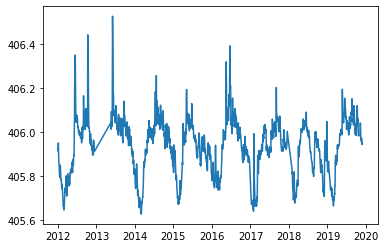

In [25]:
plt.plot(merged_df["water_level"])

In [49]:
startdate = pd.to_datetime("2013-06-06").date()

final_df = merged_df.loc[merged_df.index>startdate]

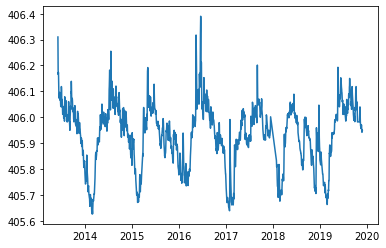

In [50]:
plt.plot(final_df["water_level"])

In [52]:
# safe dataframe as csv
final_df.to_csv("../data/daily_data.csv", index=True)
